In [16]:
import pandas as pd
import numpy as np
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../../')))



df = pd.read_csv(os.path.join(os.getcwd(), "../../data/total_4am.csv"), index_col=0)

df

,day_starting_at_4am,open,high,low,close,volume_krw,volume_market
0,2021-03-31 04:00:00,70913000.0,72000000.0,70838000.0,71672000.0,8.072377e+10,1128.289061
1,2021-04-01 04:00:00,71619000.0,73117000.0,70670000.0,72997000.0,6.635804e+11,9202.724442
2,2021-04-02 04:00:00,72997000.0,74400000.0,71841000.0,73791000.0,6.514828e+11,8859.982312
3,2021-04-03 04:00:00,73790000.0,75703000.0,73100000.0,74815000.0,5.678623e+11,7604.545110
4,2021-04-04 04:00:00,74815000.0,75100000.0,71570000.0,73090000.0,6.160404e+11,8423.984650
...,...,...,...,...,...,...,...
1232,2024-08-14 04:00:00,84725000.0,85950000.0,82483000.0,82732000.0,3.119777e+11,3703.563056
1233,2024-08-15 04:00:00,82732000.0,83555000.0,81048000.0,81437000.0,2.546273e+11,3093.291193
1234,2024-08-16 04:00:00,81436000.0,83040000.0,79500000.0,82912000.0,2.868403e+11,3534.627568
1235,2024-08-17 04:00:00,82911000.0,83400000.0,82042000.0,82766000.0,9.552768e+10,1156.014190


In [17]:
import pandas as pd
import numpy as np

# Assuming the dataframe is named df
# Calculate the price change
df['price_change'] = df['close'].diff()

# Calculate the gains and losses
df['gain'] = np.where(df['price_change'] > 0, df['price_change'], 0)
df['loss'] = np.where(df['price_change'] < 0, -df['price_change'], 0)

# Calculate the average gain and average loss
window_length = 14
df['avg_gain'] = df['gain'].rolling(window=window_length, min_periods=1).mean()
df['avg_loss'] = df['loss'].rolling(window=window_length, min_periods=1).mean()

# Calculate the RS (Relative Strength) and RSI
df['rs'] = df['avg_gain'] / df['avg_loss']
df['rsi'] = 100 - (100 / (1 + df['rs']))

# Implement RSI strategy for long positions only
df['signal'] = 0  # Default to no position
for i in range(1, len(df)):
    # Buy signal
    if (df['rsi'].iloc[i] >= 30) and (df['rsi'].iloc[i-1] < 30):
        df['signal'].iloc[i] = 1
    # Sell signal
    elif (df['rsi'].iloc[i] <= 70) and (df['rsi'].iloc[i-1] > 70):
        df['signal'].iloc[i] = -1

# Manage positions with stop loss, take profit, and sell signal
df['position'] = 0
df['highest_price'] = np.nan
df['exit_price'] = np.nan
holding_position = False

for i in range(1, len(df)):
    if df['signal'].iloc[i] == 1 and not holding_position:
        # Enter position
        df['position'].iloc[i] = 1
        # df['entry_price'].iloc[i] = df['close'].iloc[i]
        df['highest_price'].iloc[i] = df['close'].iloc[i]
        holding_position = True
    elif holding_position:
        # Calculate percentage change since entry
        df['highest_price'].iloc[i] = max(df['highest_price'].iloc[i-1], df['close'].iloc[i])
        highest_price = df['highest_price'].iloc[i]
        current_price = df['close'].iloc[i]
        percent_change = (current_price - highest_price) / highest_price * 100

        if df['signal'].iloc[i] == -1:  # Sell signal condition
            print(f"cond1 on{i}")
            df['position'].iloc[i] = 0
            df['exit_price'].iloc[i] = current_price
            holding_position = False
        elif percent_change <= -5:  # Stop loss condition
            print(f"cond2 on{i}")
            df['position'].iloc[i] = 0
            df['exit_price'].iloc[i] = current_price
            holding_position = False
        # elif percent_change >= 30:  # Take profit condition
        #     print(f"cond3 on{i}")
        #     df['position'].iloc[i] = 0
        #     df['exit_price'].iloc[i] = current_price
        #     holding_position = False
        else:
            # Continue holding the position if no sell conditions are met
            df['position'].iloc[i] = df['position'].iloc[i-1]
            # df['entry_price'].iloc[i] = df['entry_price'].iloc[i-1]
    else:
        # No signal and no position
        df['position'].iloc[i] = df['position'].iloc[i-1]

# Calculate the strategy returns (only when in a long position)
df['strategy_returns'] = df['position'].shift(1) * df['close'].pct_change()

# Calculate the cumulative returns
df['cumulative_returns'] = (1 + df['strategy_returns']).cumprod()

# Calculate the benchmark cumulative returns (buy and hold strategy)
df['benchmark_returns'] = (1 + df['close'].pct_change()).cumprod()

# Display the results
print(df[['day_starting_at_4am', 'close', 'rsi', 'signal', 'position', 'cumulative_returns', 'benchmark_returns',  'exit_price']].tail(10))

df.to_csv("../../results/rsi/rsi_with_stoploss_highest.csv")


/var/folders/99/rgk848td545d3hdrkgrkw0t40000gn/T/ipykernel_11384/962218446.py:29: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['signal'].iloc[i] = -1
/var/folders/99/rgk848td545d3hdrkgrkw0t40000gn/T/ipykernel_11384/962218446.py:29: Setti

cond1 on41
cond2 on66
cond2 on79
cond1 on118
cond1 on205
cond2 on240
cond2 on247
cond2 on253
cond2 on257
cond2 on272
cond2 on296
cond1 on314
cond2 on338
cond2 on391
cond2 on429
cond2 on456
cond1 on531
cond2 on559
cond2 on625
cond1 on670
cond2 on708
cond1 on730
cond2 on768
cond2 on796
cond1 on826
cond1 on869
cond2 on884
cond1 on916
cond1 on1083
cond2 on1126
cond1 on1149
cond2 on1191
cond1 on1216
      day_starting_at_4am       close        rsi  signal  position  \
1227  2024-08-09 04:00:00  84889000.0  36.809816       0         1   
1228  2024-08-10 04:00:00  85650000.0  35.308896       0         1   
1229  2024-08-11 04:00:00  84657000.0  35.057683       0         1   
1230  2024-08-12 04:00:00  82222000.0  33.519432       0         1   
1231  2024-08-13 04:00:00  84782000.0  40.053662       0         1   
1232  2024-08-14 04:00:00  82732000.0  36.693486       0         1   
1233  2024-08-15 04:00:00  81437000.0  39.693413       0         1   
1234  2024-08-16 04:00:00  82912000.0  42.

In [18]:
from performance import get_performance

get_performance(df=df, title="rsi_basic_cut")

======Investment Summary======
Strategy        : rsi_basic_cut
total_return    : 286.32
cagr            : 49.0
mdd             : 28.6


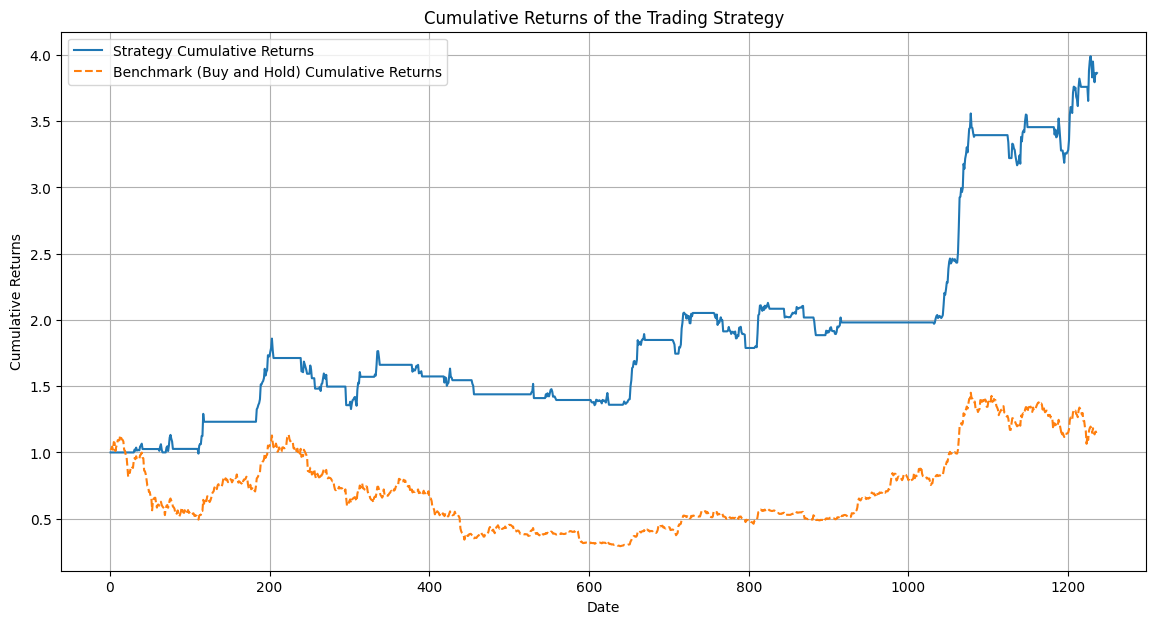

In [19]:
import matplotlib.pyplot as plt
# Plot the cumulative returns
plt.figure(figsize=(14, 7))
plt.plot(df['cumulative_returns'], label='Strategy Cumulative Returns')
plt.plot(df['benchmark_returns'], label='Benchmark (Buy and Hold) Cumulative Returns', linestyle='--')
plt.title('Cumulative Returns of the Trading Strategy')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()
